# Optimization of a circulator layout

Author: Alexis Morvan
Date: 2021-06-02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../")

from freq_allocation.yield_mc_simulation import *
from freq_allocation.frequency_graph import FrequencyGraph
from freq_allocation.optimization import layout_optimizer

# silencing pyomo wanring
import logging

logging.getLogger('pyomo.core').setLevel(logging.ERROR)

# import pandas as pd

## Definition of the layout
We are defining a circular layout of N-transmons. Here we consider a simple circular layout where the edge goes likes:

0 --> 1 --> 2 --> ... --> N//2 <-- ... <-- N-1 <-- N <-- 0

In [2]:
architecture = "CZ"  # choosing the architecture: CZ or CR
cz = True if architecture=='CZ' else False
qutrit = False # qutrit or qubits

# for later:
# thresholds
# weights
all_differents = False
# solver name

In [3]:
#thresholds
if architecture == 'CR':
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017, 0.0])
#     d = np.array([0.017, 0.03 , 0.03 , 0.0, 0.0 , 0.00, 0.0, 0.0, 0.0, 0.0])
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "F1", "F2", "M1", "C1"]
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cr_keys = ['A1', 'A2i', 'A2j', "E1", "E2","E4","C1", "C1b", "F1", "F2", "M1"]
    cstr_key = cr_keys

#CZ constraints
elif architecture == 'CZ':
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1", "C1", "C2"]
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017, 0.0, 0.0])
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cstr_key = keys

# free of drive
# keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
# d = np.array([0.017, 0.03 , 0.03 , 0.00, 0.00 , 0.000, 0.00, 0.00 , 0.000, 0.00, 0.00, 0.00])
# d_dict = { k: dd for (k, dd) in zip(keys, d)}
# cstr_key = keys

In [4]:
# d_dict = {key : d_dict[key] for key in ['A1', 'A2i', 'A2j']}

### Ring parameters

True
True


KeyboardInterrupt: 

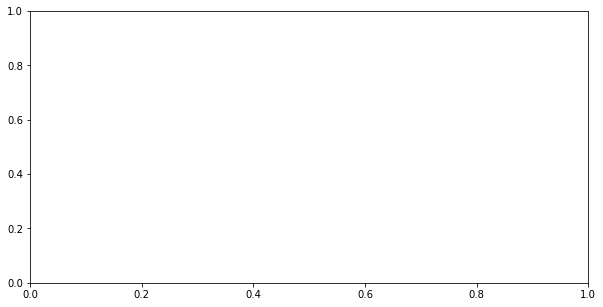

In [6]:
N_large = 100

N_vec = np.arange(4, 5, 1)

# N_samples
Nsamples = 50

# varying the dispersion of the frequency
s_vec =np.linspace(0, 0.01, 21) # list(np.linspace(0, 0.010, 101)) + list(np.linspace(0.010, 0.0115, 201)) + list(np.linspace(0.0115, 0.015, 21))
s_vec = np.array(s_vec)

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))


data = np.zeros((len(N_vec), len(s_vec)))
window = np.zeros((len(N_vec)))

for n, N in enumerate(N_vec):

    edges = [(k, k+1) for k in range(N//2)]
    edges += [(k, k-1) for k in range(N//2+1, N)]
    edges += [(0, N-1)]
    G = FrequencyGraph(edges=edges, cz=cz)
#     G.plot()
    optimizer = layout_optimizer(graph=G,
                                 architecture=architecture,
                                 qutrit=qutrit,
                                 all_differents=all_differents,
                                constraint_dict=d_dict)

    # perform the optimization
    optimizer.declare_solver()
    result = optimizer.first_pass()
    optimizer.second_pass()
    result = optimizer.third_pass()

    freqs, anharms, drives = optimizer.get_solution()
    G.set_values(freqs, anharms, drives)
    print(G.check_solution(d_dict, cstr=cstr_key))


    window[n] = max((list(freqs.values()))) - min(list(freqs.values()))
    
    ncell = N
    # periodicity boundary:
    boundary = [0, N]

    # frequency and anharmonicity are like the cell one, but with modulo
    freqs = {k: G.freqs[k%ncell] for k in range(N_large)}
    anharms = {k: G.anharmonicity[k%ncell] for k in range(N_large)} 
    drives = {}

    edges = []
    # loop through the nodes and add the edge as well as the frequency
    for nn in range(N_large):

        # loop through the small cell
        for e in G.edges:
            drive = G.drive[e]
            i, j = e 
            if i == nn % ncell:

                # check that we are not on a repeated edge:    
                if (i in boundary) and (j in boundary):
                    if j>i:
                        i += ncell
                    elif j<i:
                        j += ncell
                    else:
                        print("weird edge (i, i)")            

                i = i + (nn//ncell)*ncell
                j = j + (nn//ncell)*ncell
                if (i<N_large) and (j<N_large):
                    edges.append((i, j))
                    drives[(i, j)] = drive

    G2 = FrequencyGraph(edges=edges, cz=cz)
    G2.set_values(freqs, anharms, drives)
    print(G2.check_solution(d_dict, cstr=cstr_key))
    
    # saving the results
    collisions = np.array([G2.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key, reoptimize=True)[0] for s in s_vec])

    n_collisions = [0]
    y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]
    data[n, :] = y[0]
    ax.plot(s_vec*1e3, y[0], label=f'length {N}')
    
    
ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

# ax.set_xlim(0, 100)
ax.grid()

In [47]:
len(G2.nodes)

999

In [11]:
res = np.zeros(len(N_vec))
for k in range(len(N_vec)):
    res[k] = None
    for i in range(len(s_vec)):
        if np.abs(data[k, i]-1)<1e-1:
            res[k] = i

In [12]:
res

array([3.])

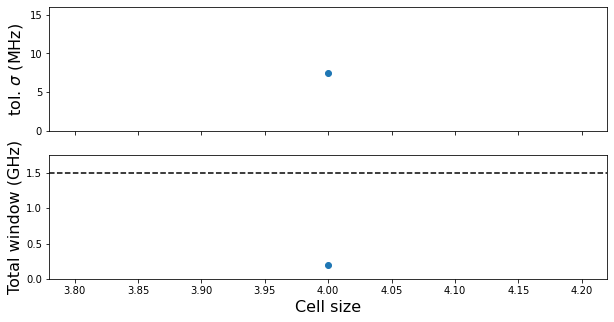

In [13]:
fig, ax = plt.subplots(2, sharex=True,  figsize=(10, 5))

ax[0].plot(N_vec, np.array([s_vec[int(r)] for r in res])*1e3, 'o--')
ax[1].plot(N_vec, window, 'o--')

ax[1].set_xlabel("Cell size", fontsize=16)
ax[0].set_ylabel("tol. $\sigma$ (MHz)", fontsize=16)
ax[1].set_ylabel("Total window (GHz)", fontsize=16)
ax[0].set_ylim(0, 16)
ax[1].set_ylim(0, 1.75)

ax[1].axhline(1.5, color='k', ls='--')

# ax[0].set_ylim(10, 12)
fig.savefig("scaling_ring.pdf")

array([8.25, 8.25, 8.25, 8.25, 8.25, 8.25, 8.25, 8.25, 8.25, 8.25, 8.25,
       7.5 ])

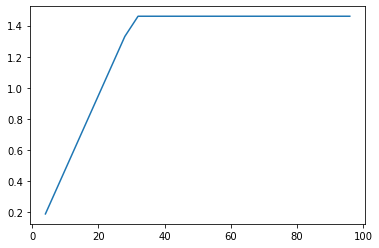

In [24]:
plt.plot(N_vec, window)

In [25]:
max((list(freqs.values()))) - min(list(freqs.values()))

1.46

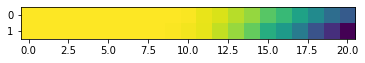

In [10]:
fig, ax = plt.subplots()
ax.imshow(data)

In [11]:
edges

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (6, 5),
 (7, 6),
 (8, 7),
 (9, 8),
 (0, 9)]

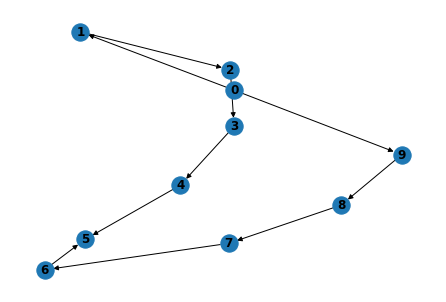

In [12]:
G = FrequencyGraph(edges=edges, cz=cz)
G.plot()

KeyError: 'freq'

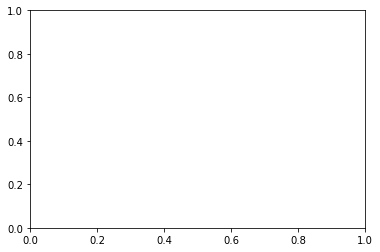

In [13]:
fig, ax = plt.subplots()
ax.plot(G.freqs, 'o--')
ax.plot()

## Yield of the design

In [14]:
# parametrization
Nsamples = 50000
sigma = 0.05

# Calculating yield
collisions, c, idx_list, constraints = G.get_collision(d_dict, sigma=sigma, qutrit=False, cstr=cstr_key, Nsamples=Nsamples)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")


###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)

#legend
ax.set_xlabel("Number of collision")
ax.set_ylabel("Frequency")
ax.set_title("Number of collision per sample")

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(cstr_key)

# legend and labels
ax.set_xlabel('Collision type')
ax.set_ylabel('Frequency')
ax.set_title("Collision type")
fig.suptitle(f"Collision for a 6q ring with $\sigma=$ {sigma} GHz")

fig.tight_layout()

KeyError: 'freq'

# Transfering to larger lattice

In [15]:
G.edges

OutEdgeView([(0, 1), (0, 9), (1, 2), (2, 3), (3, 4), (4, 5), (6, 5), (7, 6), (8, 7), (9, 8)])

The drive frequency are CR compatible
True


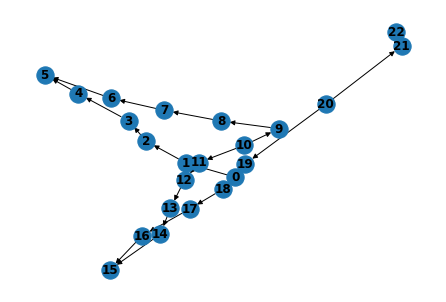

In [19]:
G2.drive

NameError: name 'G2' is not defined

In [20]:
G2.freqs

NameError: name 'G2' is not defined

KeyError: 9

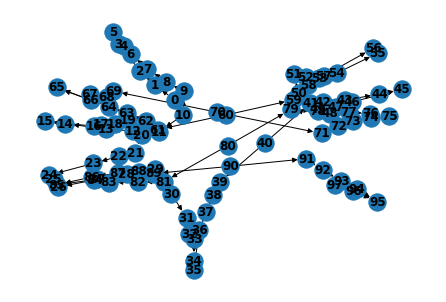

In [21]:
G2 = FrequencyGraph(edges=edges, cz=cz)
G2.plot()
G2.set_values(freqs, anharms, drives)
print(G2.check_solution(d_dict, cstr=cstr_key))

In [34]:
G.check_solution(d_dict, cstr=cstr_key)

True

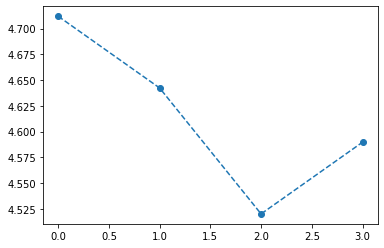

In [36]:
fig, ax = plt.subplots()
ax.plot(G.freqs, 'o--')

Qubit collisions:
yield   = 0.0382
average = 3.4438


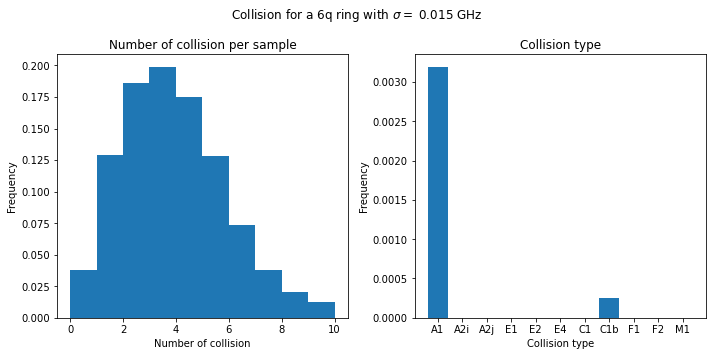

In [34]:
# parametrization
Nsamples = 5000
sigma = 0.015

# Calculating yield
collisions, c, idx_list, constraints = G2.get_collision(d_dict, sigma=sigma, qutrit=False, cstr=cstr_key, Nsamples=Nsamples)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")


###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)

#legend
ax.set_xlabel("Number of collision")
ax.set_ylabel("Frequency")
ax.set_title("Number of collision per sample")

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(cstr_key)

# legend and labels
ax.set_xlabel('Collision type')
ax.set_ylabel('Frequency')
ax.set_title("Collision type")
fig.suptitle(f"Collision for a 6q ring with $\sigma=$ {sigma} GHz")

fig.tight_layout()

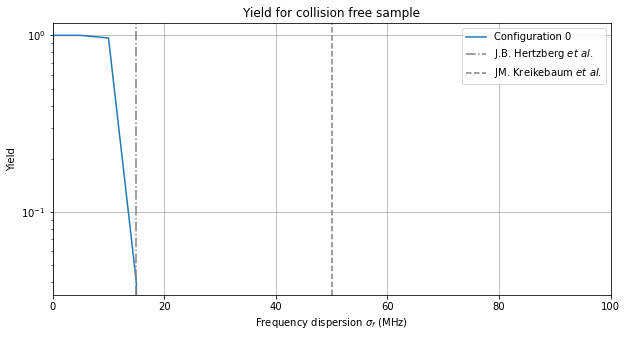

In [37]:
# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

# N_samples
Nsamples = 1000

# varying the dispersion of the frequency
s_vec = np.linspace(0, 0.1, 21)

# saving the results
collisions = np.array([G2.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')


ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

ax.set_xlim(0, 100)
ax.grid()

In [103]:
data = {"sigma": s_vec, 
        "collisions": collisions,
        "key": cstr_key,
        "yield": y,
        "samples":Nsamples}
np.save(f'ring_8t_{architecture}_yield_2x4.npy',data)

In [104]:
data_CR = np.load('ring_8t_CR_yield.npy', allow_pickle=True)[()]

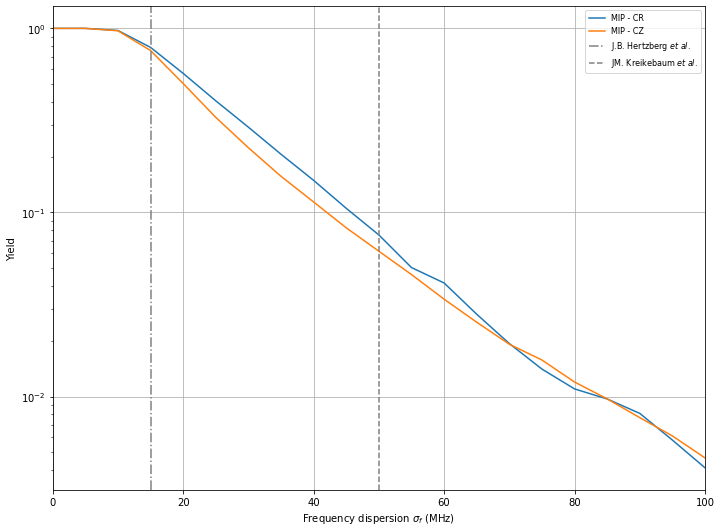

In [105]:
fig, ax = plt.subplots(figsize=(3*3.375, 3*2.5))


s_vec_cr = data_CR["sigma"]
y_cr = data_CR["yield"]

s_vec_cz = data["sigma"]
y_cz = data["yield"]



ax.plot(s_vec_cr*1e3, y_cr[0], label=f'MIP - CR')
ax.plot(s_vec_cz*1e3, y_cz[0], label=f'MIP - CZ')

ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
# ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=8, loc=0)

ax.set_xlim(0, 100)
ax.grid()

fig.tight_layout()

# fig.savefig("fig_yield_ring.pdf")

In [10]:
# Histogram of tolerance for 1000 qubits

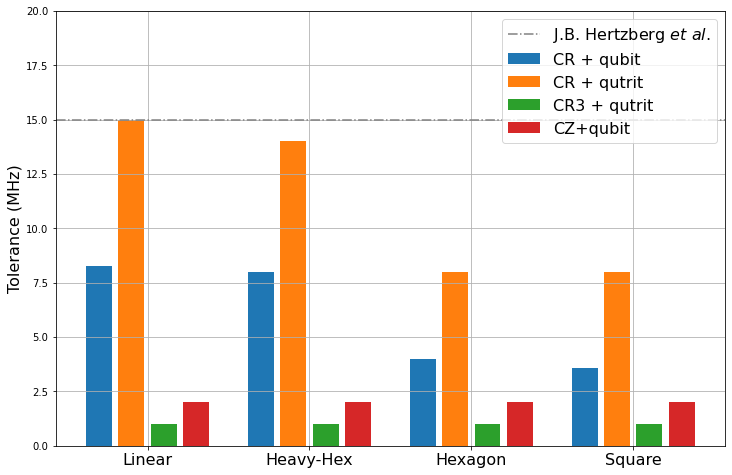

In [38]:
# CR qubits
# ring of qubits: 8.25 MHz
# square: 3.6
# hexagon: 4 
# heavy hexagon: 8
fs = 16


r = [[8.25, 8, 4, 3.6],
     [15, 14, 8, 8],
     [1, 1, 1, 1],
     [2,2,2,2]]

labels = ["CR + qubit", "CR + qutrit", "CR3 + qutrit", "CZ+qubit", "CZ+qutrit"]

ntypes = len(r)

c = [2, 2.4, 3, 4]

fig, ax = plt.subplots(figsize=(12, 8))
ax.grid()

for i in range(ntypes):
    ax.bar([k*(ntypes+1) + i for k in range(4)], r[i], label=labels[i])



ax.set_xticks([k*(ntypes+1)+len(r)/2 - 0.5 for k in range(4)])
ax.set_xticklabels(['Linear', "Heavy-Hex", "Hexagon", "Square"], fontsize=fs)
ax.set_ylim(0, 20)
ax.set_ylabel("Tolerance (MHz)", fontsize=fs)

ax.axhline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axhline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

ax.legend(fontsize=fs)

